In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
from joblib import Parallel, delayed

path_root = '../../../data'
path_data = '../../../data'
target_name = 'target'
scores_folds = {}

In [2]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return (np.sqrt(np.sum(series_log_return**2)))

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred)/y_true)))

def get_stock_stat(stock_id: int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    # stock features
    df_book = pd.read_parquet(path_root+f'/book_{dataType}.parquet/stock_id={stock_id}')
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1']*df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1']) / (
                            df_book['ask_size1'] + df_book['bid_size1'])
    df_book['wap2'] = (df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size2'] + df_book['bid_size2'])
    df_book['log_return1'] = df_book.groupby(by=['time_id'])['wap1'].apply(log_return).fillna(0)
    df_book['log_return2'] = df_book.groupby(by=['time_id'])['wap2'].apply(log_return).fillna(0)
    
    # Ryotaro Features
    df_book['typical_price'] = (df_book['bid_price1'] + df_book['ask_price1'] + df_book['wap1']) / 3
    features_to_apply_realized_volatility = ['log_return'+str(i) for i in range(1, 3)]
    features_to_apply_realized_volatility += ['typical_price']
    stock_stat = df_book.groupby(by=['stock_id', 'time_id'])[features_to_apply_realized_volatility].agg(realized_volatility).reset_index()
    
    # trade features
    trade_stat = pd.read_parquet(path_root + f'/trade_{dataType}.parquet/stock_id={stock_id}')
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    trade_stat['trade_log_return1'] = trade_stat.groupby(by=['time_id'])['price'].apply(log_return).fillna(0)
    trade_stat = trade_stat.groupby(by=['stock_id', 'time_id'])[['trade_log_return1']].agg(realized_volatility).reset_index()
    
    # joining book and trade features
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left').fillna(-999)
    return stock_stat

def get_dataSet(stock_ids: list, dataType='train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType)
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index=True)
    return stock_stat_df

train = pd.read_csv(path_root + '/train.csv')
train_stock_stat_df = get_dataSet(stock_ids=train['stock_id'][:5].unique(), dataType='train')
train = pd.merge(train, train_stock_stat_df, on=['stock_id', 'time_id'], how='left').fillna(0)

In [26]:
# items: pd.Series
def log_1_return(items):
    items = items + 1
    return np.log(items + 1).diff()

def get_stock_stat(stock_id: int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    # book data
    # bid_price1(2), ask_price1(2), bid_size1(2), ask_size1(2)
    df_book = pd.read_parquet(path_root+f'/book_{dataType}.parquet/stock_id={stock_id}')
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    # WAP
    df_book['wap1'] = (df_book['bid_price1']*df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1']) / (
                            df_book['ask_size1'] + df_book['bid_size1'])
    
    df_book['wap2'] = (df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size2'] + df_book['bid_size2'])
    
    df_book['wap3'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1'] + df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size1'] + df_book['bid_size1'] + df_book['ask_size2'] + df_book['bid_size2'])
    
    features_to_apply_realized_volatility = []
    for i in range(1, 4):
        df_book[f'log_return{i}'] = df_book.groupby(by=['time_id'])[f'wap{i}'].apply(log_return).fillna(0)
        features_to_apply_realized_volatility += [f"log_return{i}"]
        
    # WAP difference and mean
    for i in range(1, 4):
        for j in range(i+1, 4):
            mean_name = f'book_wap{i}_{j}_mean'
            diff_name = f'book_wap{i}_{j}_diff'
            
            df_book[mean_name] = (df_book[f'wap{i}'] + df_book[f'wap{j}']) / 2
            df_book[diff_name] = df_book[f'wap{i}'] - df_book[f'wap{j}']
            
            features_to_apply_realized_volatility += [mean_name, diff_name]

            
    # other orderbook features
    df_book['book_price_spread1'] = (df_book['ask_price1'] - df_book['bid_price1']) / (df_book['ask_price1'] + df_book['bid_price1'])
    df_book['book_price_spread2'] = (df_book['ask_price2'] - df_book['bid_price2']) / (df_book['ask_price2'] + df_book['bid_price2'])
    df_book['book_bid_spread'] = df_book['bid_price1'] - df_book['bid_price2']
    df_book['book_bid_spread_a'] = (df_book['bid_price1'] - df_book['bid_price2']) / (df_book['bid_price1'] + df_book['bid_price2'])
    df_book['book_ask_spread'] = df_book['ask_price1'] - df_book['ask_price2']
    df_book['book_ask_spread_a'] = (df_book['ask_price1'] - df_book['ask_price2']) / (df_book['ask_price1'] + df_book['ask_price2'])
    df_book['book_total_volume'] = df_book['ask_size1'] + df_book['ask_size2'] + df_book['bid_size1'] + df_book['bid_size2']
    df_book['book_volume_imbalance'] = (df_book['ask_size1'] + df_book['ask_size2']) - (df_book['bid_size1'] + df_book['bid_size2'])
    features_to_apply_realized_volatility += ['book_price_spread1', 'book_price_spread2', 'book_bid_spread','book_bid_spread_a',
                                              'book_ask_spread', 'book_ask_spread_a', 'book_total_volume', 'book_volume_imbalance']
            
            
        

    # Ryotaro Features
    df_book['typical_price'] = (df_book['bid_price1'] + df_book['ask_price1'] + df_book['wap1']) / 3
    df_book['TypicalPrice_log_return'] = df_book.groupby(by=['time_id'])['typical_price'].apply(log_return).fillna(0)
    features_to_apply_realized_volatility += ['TypicalPrice_log_return']
    stock_stat = df_book.groupby(by=['stock_id', 'time_id'])[features_to_apply_realized_volatility].agg(realized_volatility).reset_index()
    
    # Trade data
    # price, size, order_count
    trade_features_realized_volatility = []
    trade_stat = pd.read_parquet(path_root+f"/trade_{dataType}.parquet/stock_id={stock_id}")
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    trade_stat['trade_log_return'] = trade_stat.groupby(by='time_id')['price'].apply(log_return).fillna(0)
    trade_features_realized_volatility += ['trade_log_return']
    
    # original features
    trade_stat['size_log_return'] = trade_stat.groupby(by='time_id')['size'].apply(log_1_return).fillna(0)
    trade_stat['orderCount_log_return'] = trade_stat.groupby(by='time_id')['order_count'].apply(log_1_return).fillna(0)
    trade_stat['volume'] = trade_stat['price'] * trade_stat['order_count']
    trade_stat['volume_log_return'] = trade_stat.groupby(by='time_id')['volume'].apply(log_1_return).fillna(0)
    trade_features_realized_volatility = ['trade_log_return', 'size_log_return', 'orderCount_log_return', 'volume_log_return']
    trade_stat = trade_stat.groupby(by=['stock_id', 'time_id'])[trade_features_realized_volatility].agg(realized_volatility).reset_index()
    
    # joining book and trade data
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left').fillna(-999)
    
    return stock_stat

def get_dataSet(stock_ids: list, dataType='train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType)
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index=True)
    return stock_stat_df

stock_ids = [0, 5, 10, 15, 20]
stock_df = get_dataSet(stock_ids)
df = pd.read_csv(path_root + '/train.csv')
df = pd.merge(df.loc[df['stock_id'].isin(stock_ids)], stock_df, on=['stock_id', 'time_id'], how='left').fillna(0)
df['new_target'] = df['target'] / df['log_return1']
df.head()

,stock_id,time_id,target,log_return1,log_return2,log_return3,book_wap1_2_mean,book_wap1_2_diff,book_wap1_3_mean,book_wap1_3_diff,...,book_ask_spread,book_ask_spread_a,book_total_volume,book_volume_imbalance,TypicalPrice_log_return,trade_log_return,size_log_return,orderCount_log_return,volume_log_return,new_target
0,0,5,0.004136,0.004499,0.006999,0.004106,17.442329,0.008464,17.442907,0.004676,...,0.003415,0.001700,6111.054573,2993.036585,0.002395,0.002006,16.743341,3.642010,3.647071,0.919188
1,0,11,0.001445,0.001204,0.002476,0.001507,14.145281,0.003707,14.145495,0.002061,...,0.002117,0.001058,6305.830159,2472.188100,0.000714,0.000901,12.502979,2.560090,2.560417,1.199426
2,0,16,0.002168,0.002369,0.004801,0.002469,13.705978,0.005647,13.705446,0.002424,...,0.003585,0.001792,6014.405706,2444.784653,0.001620,0.001961,11.590192,2.984806,2.983895,0.915385
3,0,31,0.002195,0.002574,0.003637,0.002708,10.940565,0.004962,10.941170,0.002486,...,0.001548,0.000774,5063.131640,2079.227260,0.001698,0.001561,6.829874,2.853436,2.852248,0.852949
4,0,62,0.001747,0.001894,0.003257,0.001932,13.261491,0.004193,13.261691,0.002125,...,0.001763,0.000882,5010.456766,2129.497828,0.001128,0.000871,11.551998,3.820016,3.819600,0.922325


In [27]:
df.describe()

,stock_id,time_id,target,log_return1,log_return2,log_return3,book_wap1_2_mean,book_wap1_2_diff,book_wap1_3_mean,book_wap1_3_diff,...,book_ask_spread,book_ask_spread_a,book_total_volume,book_volume_imbalance,TypicalPrice_log_return,trade_log_return,size_log_return,orderCount_log_return,volume_log_return,new_target
count,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,...,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000,19150.000000
mean,10.000000,16038.933681,0.003861,0.004209,0.005827,0.004025,19.207479,0.006438,19.207502,0.003334,...,0.003983,0.001990,15253.367062,6059.290075,0.002901,0.002519,16.446133,5.008253,5.008227,0.982741
std,7.071252,9365.283647,0.002703,0.003315,0.004718,0.003017,3.751879,0.005931,3.751845,0.003071,...,0.002986,0.001490,16805.367619,9555.889581,0.002146,0.001847,5.510185,2.194036,2.194101,0.289369
min,0.000000,5.000000,0.000594,0.000648,0.000831,0.000615,8.540896,0.000952,8.541541,0.000585,...,0.000521,0.000260,-999.000000,-999.000000,0.000408,0.000000,0.109771,0.223144,0.224138,0.264066
25%,5.000000,7854.000000,0.002131,0.002167,0.002988,0.002146,15.995107,0.002838,15.995621,0.001511,...,0.002426,0.001213,5867.014359,2703.721776,0.001588,0.001373,12.568326,3.438044,3.438305,0.805398
50%,10.000000,15852.500000,0.003066,0.003195,0.004447,0.003116,19.513838,0.004835,19.514064,0.002446,...,0.003287,0.001642,10627.390249,4100.658056,0.002241,0.001944,15.804873,4.546943,4.545882,0.943035
75%,15.000000,23994.000000,0.004685,0.005082,0.006961,0.004864,22.742207,0.007795,22.742152,0.004039,...,0.004418,0.002210,17014.620985,6466.283197,0.003461,0.003014,19.709763,6.099345,6.099166,1.109260
max,20.000000,32767.000000,0.049287,0.068003,0.086670,0.049549,25.098444,0.121503,25.098509,0.074637,...,0.070575,0.036644,691229.650310,668119.489764,0.039023,0.031614,45.154852,19.396915,19.527008,6.253447


IndexError: index 20 is out of bounds for axis 0 with size 20

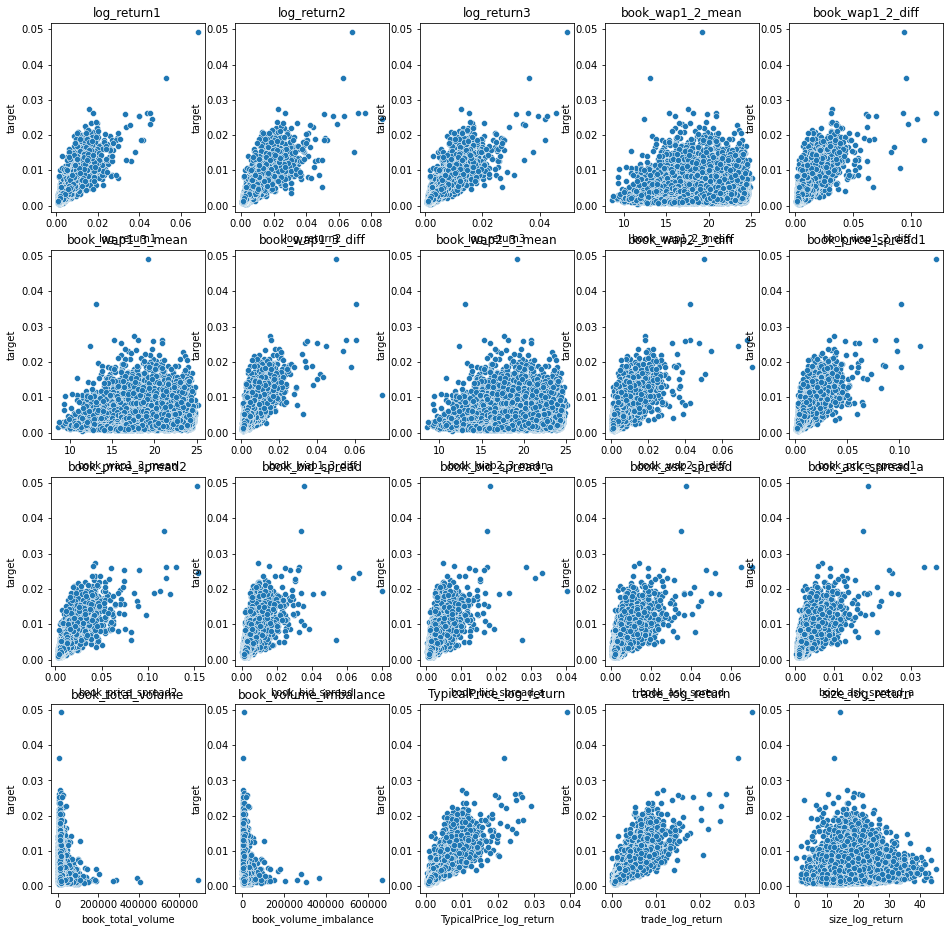

In [28]:
fig, axs = plt.subplots(4, 5, figsize=(16, 16))
axs = axs.flatten()
cols = [col for col in df.columns if not col in ['stock_id', 'time_id', 'target']]
for i in range(len(cols)):
    ax = axs[i]
    sns.scatterplot(data=df, x=cols[i], y='target', ax=ax)
    ax.set_title(cols[i])
    
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(16, 16))
axs = axs.flatten()
cols = ["TypicalPrice_log_return", "log_return1", "log_return2", "trade_log_return", "orderPerSize", "volume"]
for i in range(len(cols)):
    ax = axs[i]
    sns.scatterplot(data=df, x=cols[i], y='new_target', ax=ax)
    ax.set_title(cols[i])
    
plt.tight_layout()